In [23]:
# https://madebyai.io/course/ai-for-finance-false-signal-detection/

In [24]:
import warnings
warnings.simplefilter("ignore")

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
import ta

In [27]:
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# 1. Load data

In [29]:
df = pd.read_csv('bitstampUSD_1-min_data_2016-01-01_to_2021-03-31.csv')

In [30]:
df.shape

(2759041, 3)

In [31]:
df.head()

,Unnamed: 0,Datetime,Close
0,2098336,2016-01-01 00:00:00,430.89
1,2098337,2016-01-01 00:01:00,430.89
2,2098338,2016-01-01 00:02:00,430.89
3,2098339,2016-01-01 00:03:00,430.89
4,2098340,2016-01-01 00:04:00,431.06


In [32]:
df['Close'] = df['Close'].ffill()

In [33]:
df = df.rename(columns={'Timestamp': 'Datetime'})

In [34]:
df = df[['Datetime','Close']]

In [35]:
df.sample(10)

,Datetime,Close
2062959,2019-12-03 14:39:00,7343.23
2647248,2021-01-12 08:48:00,35779.61
955829,2017-10-25 18:29:00,5553.81
1431134,2018-09-20 20:14:00,6419.99
2746633,2021-03-22 09:13:00,57185.74
1951396,2019-09-17 03:16:00,10225.17
1671556,2019-03-06 19:16:00,3849.90
1312237,2018-06-30 06:37:00,6391.21
558162,2017-01-22 14:42:00,901.97
2391103,2020-07-18 11:43:00,9164.14


In [36]:
df.shape

(2759041, 2)

# 2. Check data quality

data type

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2759041 entries, 0 to 2759040
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Datetime  object 
 1   Close     float64
dtypes: float64(1), object(1)
memory usage: 42.1+ MB


In [38]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

unique value

In [39]:
df.shape

(2759041, 2)

In [40]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  Datetime
Unique value:  <DatetimeArray>
['2016-01-01 00:00:00', '2016-01-01 00:01:00', '2016-01-01 00:02:00',
 '2016-01-01 00:03:00', '2016-01-01 00:04:00', '2016-01-01 00:05:00',
 '2016-01-01 00:06:00', '2016-01-01 00:07:00', '2016-01-01 00:08:00',
 '2016-01-01 00:09:00',
 ...
 '2021-03-30 23:51:00', '2021-03-30 23:52:00', '2021-03-30 23:53:00',
 '2021-03-30 23:54:00', '2021-03-30 23:55:00', '2021-03-30 23:56:00',
 '2021-03-30 23:57:00', '2021-03-30 23:58:00', '2021-03-30 23:59:00',
 '2021-03-31 00:00:00']
Length: 2759041, dtype: datetime64[ns]
Count unique value:  2759041
----------
Columns name:  Close
Unique value:  [  430.89   431.06   430.54 ... 58723.84 58760.59 58778.18]
Count unique value:  1015523
----------


missing value

In [41]:
df.isnull().sum()

Datetime    0
Close       0
dtype: int64

zero value

In [42]:
(df == 0).sum()

Datetime    0
Close       0
dtype: int64

blank value

In [43]:
(df == '').sum()

Datetime    0
Close       0
dtype: int64

# 3. Create signal

In [44]:
# Define Short-Term = 30
# Define Short-Term = 300

In [45]:
df['EMA_30'] = df['Close'].ewm(span=30, adjust=False).mean()
df['EMA_300'] = df['Close'].ewm(span=300, adjust=False).mean()

In [46]:
df['Cross_Up'] = ((df['EMA_30'] > df['EMA_300']) & (df['EMA_30'].shift(1) < df['EMA_300'].shift(1))).astype(int)
df['Cross_Down'] = ((df['EMA_30'] < df['EMA_300']) & (df['EMA_30'].shift(1) > df['EMA_300'].shift(1))).astype(int)

In [47]:
df['Signal_type'] = df.apply(
    lambda x: 'BUY' if x['Cross_Up'] == 1 else ('SELL' if x['Cross_Down'] == 1 else 'NO SIGNAL'), axis=1)

In [48]:
df.head()

,Datetime,Close,EMA_30,EMA_300,Cross_Up,Cross_Down,Signal_type
0,2016-01-01 00:00:00,430.89,430.890000,430.89000,0,0,NO SIGNAL
1,2016-01-01 00:01:00,430.89,430.890000,430.89000,0,0,NO SIGNAL
2,2016-01-01 00:02:00,430.89,430.890000,430.89000,0,0,NO SIGNAL
3,2016-01-01 00:03:00,430.89,430.890000,430.89000,0,0,NO SIGNAL
4,2016-01-01 00:04:00,431.06,430.900968,430.89113,0,0,NO SIGNAL


In [49]:
df['Cross_Up'].value_counts()

Cross_Up
0    2747860
1      11181
Name: count, dtype: int64

In [50]:
df['Cross_Down'].value_counts()

Cross_Down
0    2747859
1      11182
Name: count, dtype: int64

In [51]:
df['Signal_type'].value_counts()

Signal_type
NO SIGNAL    2736678
SELL           11182
BUY            11181
Name: count, dtype: int64

In [52]:
df.head()

,Datetime,Close,EMA_30,EMA_300,Cross_Up,Cross_Down,Signal_type
0,2016-01-01 00:00:00,430.89,430.890000,430.89000,0,0,NO SIGNAL
1,2016-01-01 00:01:00,430.89,430.890000,430.89000,0,0,NO SIGNAL
2,2016-01-01 00:02:00,430.89,430.890000,430.89000,0,0,NO SIGNAL
3,2016-01-01 00:03:00,430.89,430.890000,430.89000,0,0,NO SIGNAL
4,2016-01-01 00:04:00,431.06,430.900968,430.89113,0,0,NO SIGNAL


# 4. Create target

In [53]:
# Get only rows that contain signal

In [54]:
df_target = df[df['Signal_type'] != 'NO SIGNAL']

In [55]:
df_target.shape

(22363, 7)

In [56]:
df_target.head(10)

,Datetime,Close,EMA_30,EMA_300,Cross_Up,Cross_Down,Signal_type
5,2016-01-01 00:05:00,430.54,430.877680,430.888796,0,1,SELL
6,2016-01-01 00:06:00,432.52,430.983636,430.899635,1,0,BUY
55,2016-01-01 00:55:00,429.85,431.055871,431.063169,0,1,SELL
146,2016-01-01 02:26:00,431.38,430.821163,430.802127,1,0,BUY
177,2016-01-01 02:57:00,430.47,430.822303,430.837882,0,1,SELL
200,2016-01-01 03:20:00,432.15,430.841213,430.812670,1,0,BUY
378,2016-01-01 06:18:00,431.97,433.061845,433.107078,0,1,SELL
412,2016-01-01 06:52:00,433.23,433.031838,433.019815,1,0,BUY
487,2016-01-01 08:07:00,432.20,433.679610,433.688967,0,1,SELL
529,2016-01-01 08:49:00,434.10,433.599954,433.598660,1,0,BUY


In [57]:
df_target['Close_lead_1'] = df_target['Close'].shift(-1)

In [58]:
df_target = df_target.dropna()

In [59]:
# Opposite trade signal method

In [60]:
df_target['Target'] = 0

In [61]:
for index, row in df_target.iterrows():
    if row['Cross_Up'] == 1 and row['Close_lead_1'] > row['Close']:
        df_target.loc[index, 'Target'] = 1
    if row['Cross_Down'] == 1 and row['Close_lead_1'] < row['Close']:
        df_target.loc[index, 'Target'] = 1

In [62]:
df_target

,Datetime,Close,EMA_30,EMA_300,Cross_Up,Cross_Down,Signal_type,Close_lead_1,Target
5,2016-01-01 00:05:00,430.54,430.877680,430.888796,0,1,SELL,432.52,0
6,2016-01-01 00:06:00,432.52,430.983636,430.899635,1,0,BUY,429.85,0
55,2016-01-01 00:55:00,429.85,431.055871,431.063169,0,1,SELL,431.38,0
146,2016-01-01 02:26:00,431.38,430.821163,430.802127,1,0,BUY,430.47,0
177,2016-01-01 02:57:00,430.47,430.822303,430.837882,0,1,SELL,432.15,0
...,...,...,...,...,...,...,...,...,...
2758643,2021-03-30 17:23:00,58839.47,58763.016107,58761.176432,1,0,BUY,58762.84,0
2758760,2021-03-30 19:20:00,58762.84,58825.938675,58827.167139,0,1,SELL,58902.94,0
2758769,2021-03-30 19:29:00,58902.94,58830.041234,58827.335375,1,0,BUY,58602.35,0
2758813,2021-03-30 20:13:00,58602.35,58835.238836,58846.327250,0,1,SELL,58841.75,0


In [63]:
# Merge to df

In [64]:
df = df.merge(df_target[['Datetime', 'Target']], on='Datetime', how='left')

In [65]:
df['Target'].value_counts()

Target
0.0    18517
1.0     3845
Name: count, dtype: int64

In [66]:
df['Target'].isnull().sum()

2736679

In [67]:
df.head()

,Datetime,Close,EMA_30,EMA_300,Cross_Up,Cross_Down,Signal_type,Target
0,2016-01-01 00:00:00,430.89,430.890000,430.89000,0,0,NO SIGNAL,NaN
1,2016-01-01 00:01:00,430.89,430.890000,430.89000,0,0,NO SIGNAL,NaN
2,2016-01-01 00:02:00,430.89,430.890000,430.89000,0,0,NO SIGNAL,NaN
3,2016-01-01 00:03:00,430.89,430.890000,430.89000,0,0,NO SIGNAL,NaN
4,2016-01-01 00:04:00,431.06,430.900968,430.89113,0,0,NO SIGNAL,NaN


# 5. Exploratory data analysis

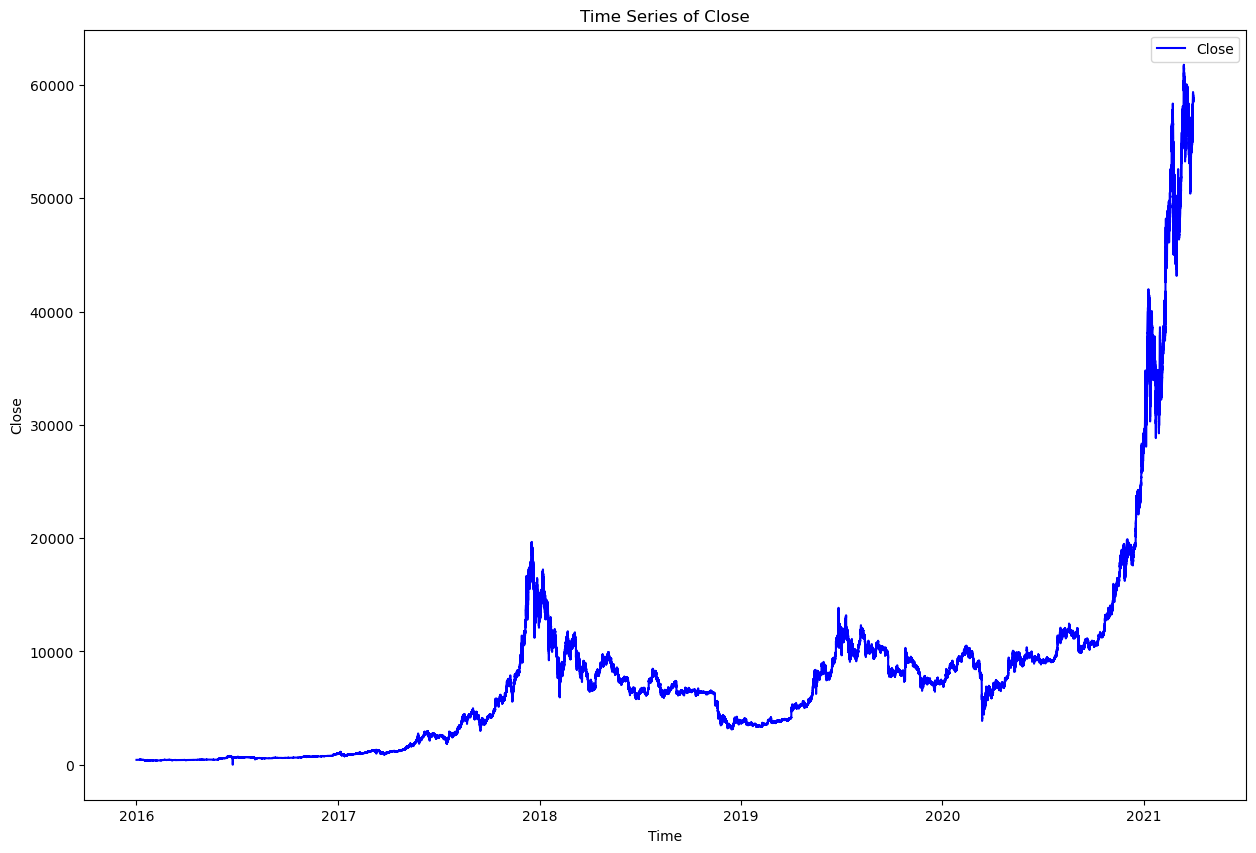

In [68]:
plt.figure(figsize=(15, 10))
plt.plot(df['Datetime'], df['Close'], label='Close', color='blue')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.title('Time Series of Close')
plt.show()

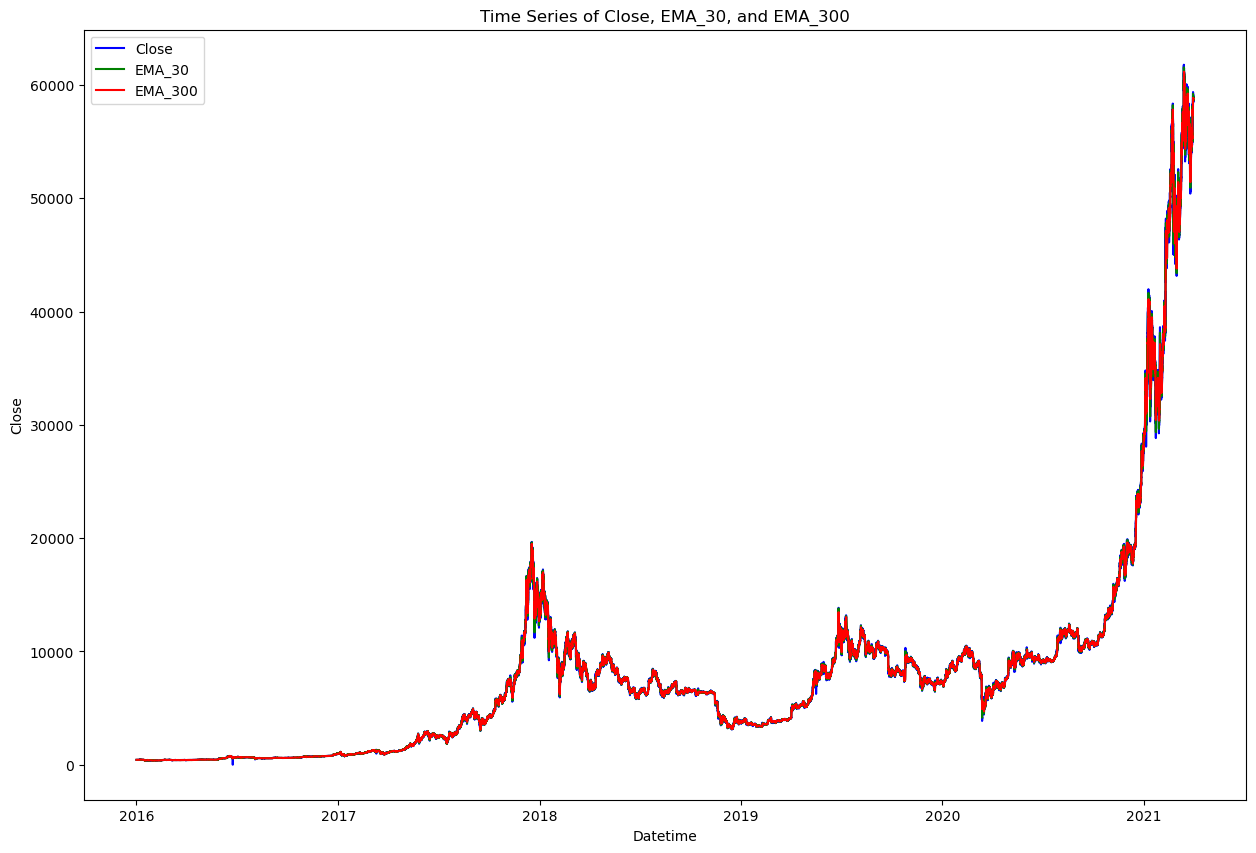

In [69]:
plt.figure(figsize=(15, 10))
plt.plot(df['Datetime'], df['Close'], label='Close', color='blue')
plt.plot(df['Datetime'], df['EMA_30'], label='EMA_30', color='green')
plt.plot(df['Datetime'], df['EMA_300'], label='EMA_300', color='red')
plt.xlabel('Datetime')
plt.ylabel('Close')
plt.legend()
plt.title('Time Series of Close, EMA_30, and EMA_300')
plt.show()

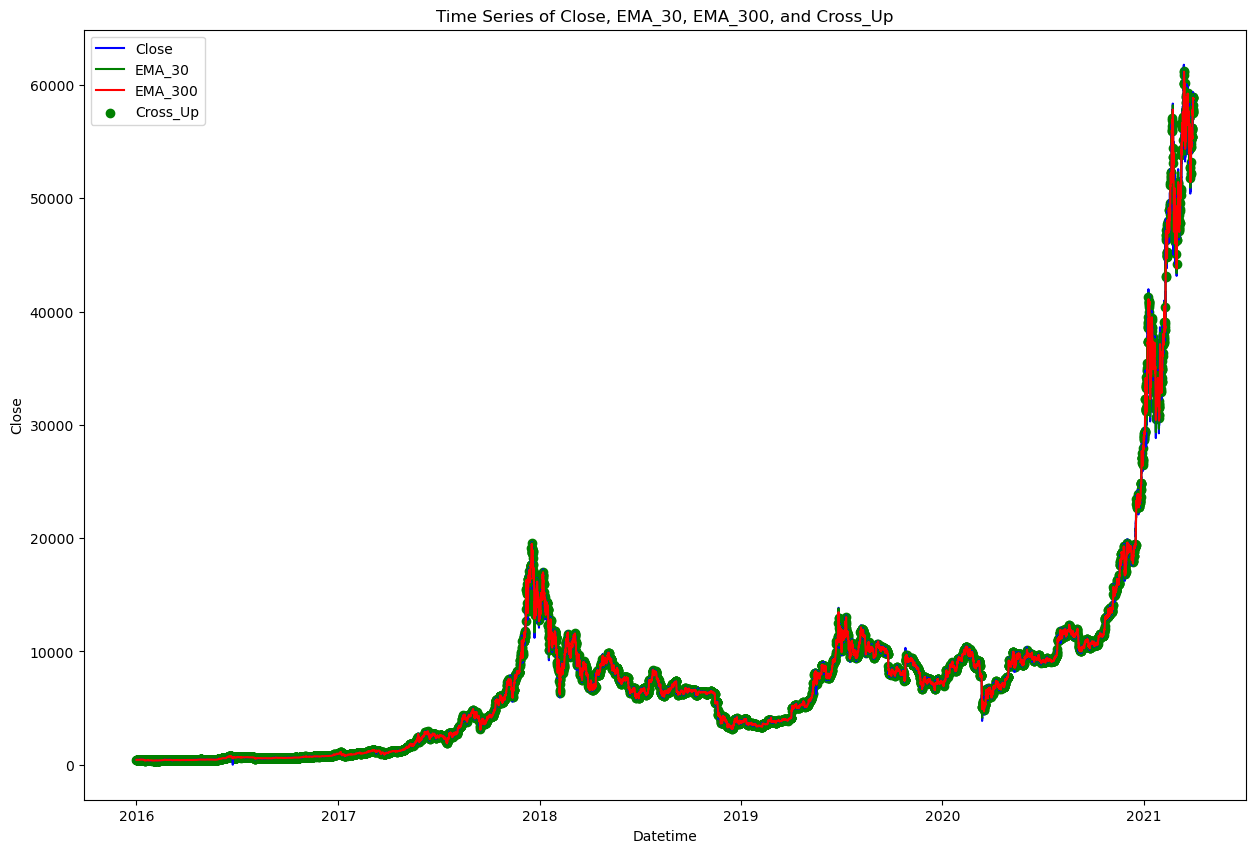

In [70]:
plt.figure(figsize=(15, 10))
plt.plot(df['Datetime'], df['Close'], label='Close', color='blue')
plt.plot(df['Datetime'], df['EMA_30'], label='EMA_30', color='green')
plt.plot(df['Datetime'], df['EMA_300'], label='EMA_300', color='red')
plt.scatter(df[df['Cross_Up'] == 1]['Datetime'], df[df['Cross_Up'] == 1]['Close'],
            color='green', marker='o', label='Cross_Up')
plt.xlabel('Datetime')
plt.ylabel('Close')
plt.legend()
plt.title('Time Series of Close, EMA_30, EMA_300, and Cross_Up')
plt.show()

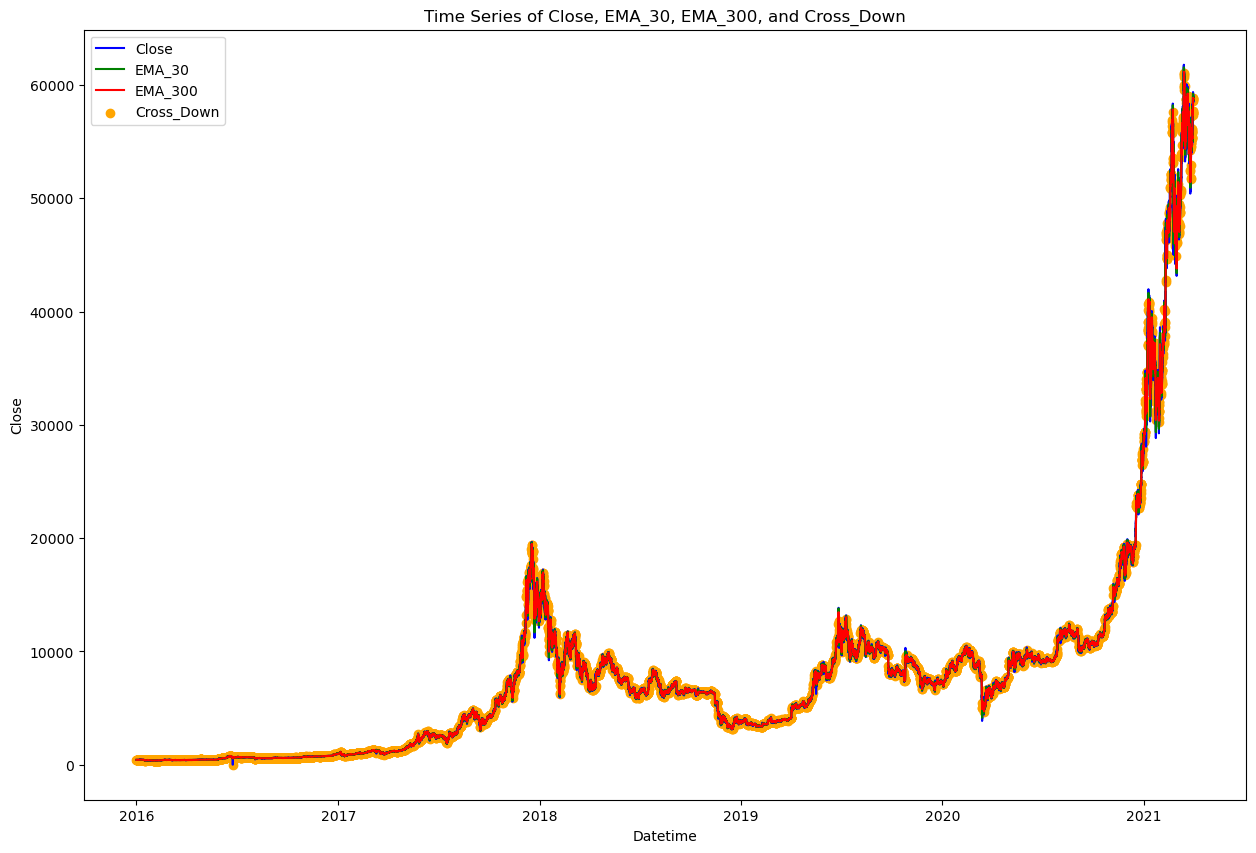

In [71]:
plt.figure(figsize=(15, 10))
plt.plot(df['Datetime'], df['Close'], label='Close', color='blue')
plt.plot(df['Datetime'], df['EMA_30'], label='EMA_30', color='green')
plt.plot(df['Datetime'], df['EMA_300'], label='EMA_300', color='red')
plt.scatter(df[df['Cross_Down'] == 1]['Datetime'], df[df['Cross_Down'] == 1]['Close'],
            color='orange', marker='o', label='Cross_Down')
plt.xlabel('Datetime')
plt.ylabel('Close')
plt.legend()
plt.title('Time Series of Close, EMA_30, EMA_300, and Cross_Down')
plt.show()

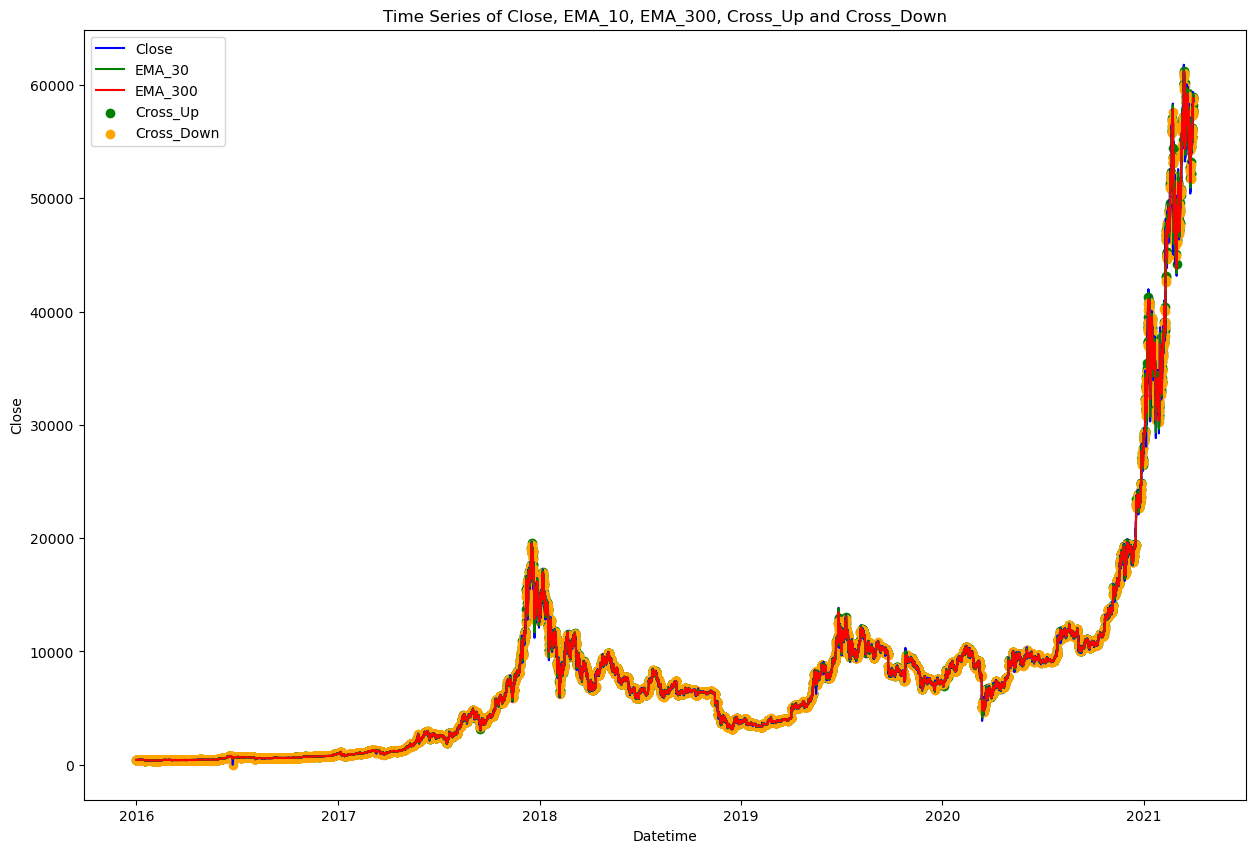

In [72]:
plt.figure(figsize=(15, 10))
plt.plot(df['Datetime'], df['Close'], label='Close', color='blue')
plt.plot(df['Datetime'], df['EMA_30'], label='EMA_30', color='green')
plt.plot(df['Datetime'], df['EMA_300'], label='EMA_300', color='red')
plt.scatter(df[df['Cross_Up'] == 1]['Datetime'], df[df['Cross_Up'] == 1]['Close'],
            color='green', marker='o', label='Cross_Up')
plt.scatter(df[df['Cross_Down'] == 1]['Datetime'], df[df['Cross_Down'] == 1]['Close'],
            color='orange', marker='o', label='Cross_Down')
plt.xlabel('Datetime')
plt.ylabel('Close')
plt.legend()
plt.title('Time Series of Close, EMA_10, EMA_300, Cross_Up and Cross_Down')
plt.show()

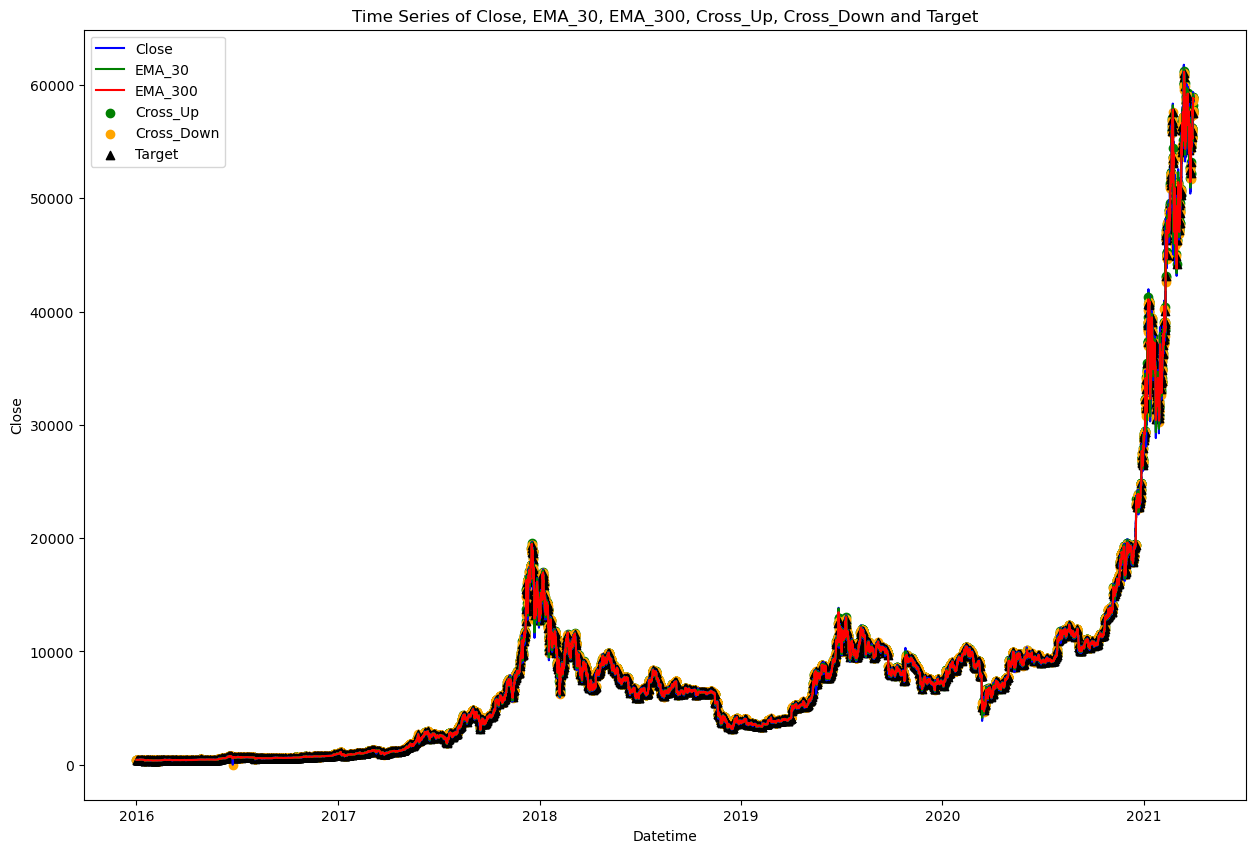

In [73]:
plt.figure(figsize=(15, 10))
plt.plot(df['Datetime'], df['Close'], label='Close', color='blue')
plt.plot(df['Datetime'], df['EMA_30'], label='EMA_30', color='green')
plt.plot(df['Datetime'], df['EMA_300'], label='EMA_300', color='red')
plt.scatter(df[df['Cross_Up'] == 1]['Datetime'], df[df['Cross_Up'] == 1]['Close'],
            color='green', marker='o', label='Cross_Up')
plt.scatter(df[df['Cross_Down'] == 1]['Datetime'], df[df['Cross_Down'] == 1]['Close'],
            color='orange', marker='o', label='Cross_Down')
plt.scatter(df[df['Target'] == 1]['Datetime'], df[df['Target'] == 1]['Close'],
            color='black', marker='^', label='Target')
plt.xlabel('Datetime')
plt.ylabel('Close')
plt.legend()
plt.title('Time Series of Close, EMA_30, EMA_300, Cross_Up, Cross_Down and Target')
plt.show()

# 6. Feature engineering

In [74]:
df = df[['Datetime','Close','Target','Signal_type']]

In [75]:
df.head()

,Datetime,Close,Target,Signal_type
0,2016-01-01 00:00:00,430.89,NaN,NO SIGNAL
1,2016-01-01 00:01:00,430.89,NaN,NO SIGNAL
2,2016-01-01 00:02:00,430.89,NaN,NO SIGNAL
3,2016-01-01 00:03:00,430.89,NaN,NO SIGNAL
4,2016-01-01 00:04:00,431.06,NaN,NO SIGNAL


In [76]:
# 3. EMA

In [77]:
ema_intervals = [3, 12, 24, 168, 336, 720]

In [78]:
for window in ema_intervals:
    column_name = f'EMA_{window}'
    df[column_name] = df['Close'].ewm(span=window, adjust=False).mean()

In [79]:
# 4. Close - EMA

In [80]:
for window in ema_intervals:
    ema_column = f'EMA_{window}'
    diff_column = f'Close1_EMA_{window}'
    df[diff_column] = df['Close'] - df[ema_column]

In [81]:
# 5. RSI

In [82]:
rsi_intervals = [3, 12, 24, 168, 336, 720]

In [83]:
for window in rsi_intervals:
    # Calculate the difference in price
    delta = df['Close'].diff(1)

    # Separate the gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the exponential moving average for gains and losses
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    # Calculate the Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the Relative Strength Index (RSI)
    rsi_column_name = f'rsi_{window}'
    df[rsi_column_name] = 100 - (100 / (1 + rs))

In [84]:
# 5. Pos_bb

In [85]:
posbb_intervals = [3, 12, 24, 168, 336, 720]

In [86]:
for window in posbb_intervals:
    rolling_window = df['Close'].rolling(window=window)
    df[f'pos_bb{window}'] = (df['Close'] - rolling_window.mean()) / (2 * rolling_window.std())

In [87]:
# 6. sd_pos

In [88]:
sdpos_intervals = [3, 12, 24, 168, 336, 720]

In [89]:
for window in sdpos_intervals:
    rolling_window = df['Close'].rolling(window=window)
    df[f'sd_pos_{window}'] = (df['Close'] - rolling_window.mean()) / rolling_window.std()

In [90]:
# 7. Drop na

In [91]:
df = df.dropna()

In [92]:
# 8. profit in point point

In [93]:
df['Close_lead_1'] = df_target['Close'].shift(-1)

In [94]:
def calculate_profit_in_points(open_price, close_price, is_buy_order):
    if is_buy_order:
        profit_in_points = (close_price - open_price)
    else:
        profit_in_points = (open_price - close_price)
    return profit_in_points

In [95]:
df['Profit_in_Points'] = df.apply(lambda row: calculate_profit_in_points(row['Close'], 
                                                                         row['Close_lead_1'], 
                                                                         row['Signal_type'] == 'BUY'),
                                  axis=1)

In [96]:
df = df.dropna()

In [97]:
df.shape

(20345, 36)

In [98]:
df.head()

,Datetime,Close,Target,Signal_type,EMA_3,EMA_12,EMA_24,EMA_168,EMA_336,EMA_720,...,pos_bb336,pos_bb720,sd_pos_3,sd_pos_12,sd_pos_24,sd_pos_168,sd_pos_336,sd_pos_720,Close_lead_1,Profit_in_Points
722,2016-01-01 12:02:00,433.25,0.0,BUY,433.351527,432.963234,432.563587,432.131967,432.454180,432.414147,...,0.130733,0.195361,-1.126742,0.543980,1.042360,2.794942,0.261466,0.390721,432.10,-1.15
922,2016-01-01 15:22:00,433.82,1.0,BUY,432.770167,432.055029,431.724686,431.268524,431.638583,431.969426,...,1.063761,0.324519,1.052346,2.637744,2.795990,2.111564,2.127521,0.649037,433.93,0.11
1530,2016-01-02 01:30:00,434.76,0.0,BUY,434.345027,434.110004,434.217961,434.533058,434.205620,433.618475,...,0.349783,0.520979,1.154701,3.174874,1.093657,0.264157,0.699566,1.041959,434.01,-0.75
1531,2016-01-02 01:31:00,434.01,1.0,SELL,434.177513,434.094619,434.201324,434.526868,434.204459,433.619561,...,-0.122950,0.264538,-0.487779,0.010501,-0.434105,-0.751717,-0.245900,0.529077,433.94,0.07
1684,2016-01-02 04:04:00,433.94,0.0,BUY,433.679816,433.638560,433.472228,433.206642,433.427053,433.365289,...,0.094100,0.205398,0.661027,0.611883,0.962592,1.388581,0.188199,0.410797,433.06,-0.88


# 7. Model

Split data

In [99]:
x_col = ['Close1_EMA_3', 'Close1_EMA_12', 'Close1_EMA_24', 'Close1_EMA_168',
         'Close1_EMA_336', 'Close1_EMA_720', 'rsi_3', 'rsi_12', 'rsi_24',
         'rsi_168', 'rsi_336', 'rsi_720', 'pos_bb3', 'pos_bb12', 'pos_bb24',
         'pos_bb168', 'pos_bb336', 'pos_bb720', 'sd_pos_3', 'sd_pos_12',
         'sd_pos_24', 'sd_pos_168', 'sd_pos_336', 'sd_pos_720']

In [100]:
y_col = ['Target']

In [101]:
profit_col = ['Signal_type','Profit_in_Points','Target']

In [102]:
# time series split

In [103]:
start_test_position = int(df.shape[0]*0.8)

In [104]:
start_test_position

16276

In [105]:
X = df[x_col]
y = df[y_col]
pip = df[profit_col]

In [106]:
X_train = X.iloc[:start_test_position]
X_test = X.iloc[start_test_position:]

y_train = y.iloc[:start_test_position]
y_test = y.iloc[start_test_position:]

pip_test = pip.iloc[start_test_position:]

ADASYN

In [107]:
adasyn = ADASYN(random_state=42)

In [108]:
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

LGBM

In [109]:
param_grid = {
    'num_leaves': [31, 62, 127],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 300, 500],
    'min_child_samples': [20, 50, 100],
    'min_child_weight': [1e-5, 1e-2, 1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

In [110]:
lgbm = LGBMClassifier(random_state=42, n_jobs=-1)

In [111]:
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

In [112]:
grid_search.fit(X_train_resampled, y_train_resampled) 

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
[LightGBM] [Info] Number of positive: 13871, number of negative: 13504
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 27375, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506703 -> initscore=0.026814
[LightGBM] [Info] Start training from score 0.026814


GridSearchCV(cv=3, estimator=LGBMClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'min_child_samples': [20, 50, 100],
                         'min_child_weight': [1e-05, 0.01, 1],
                         'n_estimators': [100, 300, 500],
                         'num_leaves': [31, 62, 127], 'subsample': [0.8, 1.0]},
             verbose=2)

In [113]:
grid_search.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.3,
 'min_child_samples': 20,
 'min_child_weight': 1e-05,
 'n_estimators': 500,
 'num_leaves': 127,
 'subsample': 0.8}

# 8. Result

In [114]:
y_pred = grid_search.predict(X_test)

In [115]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

In [116]:
print(f"Accuracy: {accuracy}")
print(f"Precision (Class 1): {precision}")
print(f"Recall (Class 1): {recall}")

Accuracy: 0.6549520766773163
Precision (Class 1): 0.245697896749522
Recall (Class 1): 0.2947247706422018


# 9. Result trading

In [117]:
pip_test['Target_predict'] = y_pred

In [118]:
pip_test.head()

,Signal_type,Profit_in_Points,Target,Target_predict
2175602,SELL,514.21,1.0,1.0
2176259,BUY,-38.34,0.0,0.0
2176343,SELL,-17.14,0.0,0.0
2176434,BUY,-15.51,0.0,0.0
2176539,SELL,-19.72,0.0,0.0


In [119]:
# Trade without false detection system

In [120]:
# No. of trade
no_trade_wos = pip_test.shape[0]
# No. of trade profit
no_trade_profit_wos = pip_test[pip_test['Profit_in_Points'] >= 0]['Profit_in_Points'].shape[0]
# No. of trade loss
no_trade_loss_wos = pip_test[pip_test['Profit_in_Points'] < 0]['Profit_in_Points'].shape[0]
# Gross profit
gross_profit_wos = pip_test[pip_test['Profit_in_Points'] >= 0]['Profit_in_Points'].sum()
# Gross loss
gross_loss_wos = pip_test[pip_test['Profit_in_Points'] < 0]['Profit_in_Points'].sum()
# Net profit
net_profit_wos = gross_profit_wos + gross_loss_wos
# Expected payoff
expected_payoff_wos = net_profit_wos/no_trade_wos
# Average profit
avg_profit_wos = gross_profit_wos/no_trade_profit_wos
# Average loss
avg_loss_wos = gross_loss_wos/no_trade_loss_wos

In [121]:
# Trade with false detection system

In [122]:
pip_test = pip_test[pip_test['Target_predict'] == 1]

In [123]:
# No. of trade
no_trade_ws = pip_test.shape[0]
# No. of trade profit
no_trade_profit_ws = pip_test[pip_test['Profit_in_Points'] >= 0]['Profit_in_Points'].shape[0]
# No. of trade loss
no_trade_loss_ws = pip_test[pip_test['Profit_in_Points'] < 0]['Profit_in_Points'].shape[0]
# Gross profit
gross_profit_ws = pip_test[pip_test['Profit_in_Points'] >= 0]['Profit_in_Points'].sum()
# Gross loss
gross_loss_ws = pip_test[pip_test['Profit_in_Points'] < 0]['Profit_in_Points'].sum()
# Net profit
net_profit_ws = gross_profit_ws + gross_loss_ws
# Expected payoff
expected_payoff_ws = net_profit_ws/no_trade_ws
# Average profit
avg_profit_ws = gross_profit_ws/no_trade_profit_ws
# Average loss
avg_loss_ws = gross_loss_ws/no_trade_loss_ws

In [124]:
summary_wos = {
    'Metric': ['No of Trades', 'No of Profit Trades', 'No of Loss Trades', 'Gross Profit', 'Gross Loss', 'Net Profit',
               'Expected Payoff', 'Avg Profit per Profit Trade', 'Avg Loss per Loss Trade'],
    'Trade without system': [no_trade_wos, no_trade_profit_wos, no_trade_loss_wos, gross_profit_wos, gross_loss_wos, net_profit_wos,
              expected_payoff_wos, avg_profit_wos, avg_loss_wos],
    'Trade with system': [no_trade_ws, no_trade_profit_ws, no_trade_loss_ws, gross_profit_ws, gross_loss_ws, net_profit_ws,
              expected_payoff_ws, avg_profit_ws, avg_loss_ws]
}

In [125]:
sum = pd.DataFrame(summary_wos)

In [126]:
sum

,Metric,Trade without system,Trade with system
0,No of Trades,4069.000000,1046.000000
1,No of Profit Trades,873.000000,257.000000
2,No of Loss Trades,3196.000000,789.000000
3,Gross Profit,261968.720000,84589.490000
4,Gross Loss,-266823.810000,-77956.230000
5,Net Profit,-4855.090000,6633.260000
6,Expected Payoff,-1.193190,6.341549
7,Avg Profit per Profit Trade,300.078717,329.141984
8,Avg Loss per Loss Trade,-83.486799,-98.803840
